# Description

From the UCI dataset website: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

**Target variable:**
- default payment (Yes = 1, No = 0)

**Explanatory variables:**
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit
- X2: Gender (1 = Male; 2 = Female)
- X3: Education (1 = Graduate; 2 = University; 3 = High School; 4 = Other)
- X4: Marital status (1 = Married; 2 = Single; 3 = Other)
- X5: Age (year)
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September 2005) as follows: 
    - X6 = repayment status in September
    - ...
    - X11 = repayment status in April 
    - The measurement scale for the repayment status is: 
        - -1 = payments current
        - 1 = delayed payment for 1 month 
        - ...
        - 9 = delayed payment for 9 months and above
- X12-X17: Amount of Billed Statement (NT dollar)
    - X12 = amount of bill statement in September
    - ...
    - X17 = amount of bill statement in April
- X18-X23: Amount of previous payment (NT dollar) 
    - X18 = amount paid in August, 2005
    - X19 = amount paid in August, 2005
    - ...
    - X23 = amount paid in April, 2005


In [1]:
# Importing Packages

import numpy as np 
import pandas as pd
import re
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use("fivethirtyeight")
import json
import requests

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_excel("/Volumes/My Passport for Mac 1/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/default of credit card clients.xls")
new_header = df.iloc[0]
df = df[1:] 
df.columns = new_header
df = df.rename(columns={"default payment next month": "default"}) 
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.dtypes

0
ID           object
LIMIT_BAL    object
SEX          object
EDUCATION    object
MARRIAGE     object
AGE          object
PAY_0        object
PAY_2        object
PAY_3        object
PAY_4        object
PAY_5        object
PAY_6        object
BILL_AMT1    object
BILL_AMT2    object
BILL_AMT3    object
BILL_AMT4    object
BILL_AMT5    object
BILL_AMT6    object
PAY_AMT1     object
PAY_AMT2     object
PAY_AMT3     object
PAY_AMT4     object
PAY_AMT5     object
PAY_AMT6     object
default      object
dtype: object

# Create train, validation, and holdout sets

In [4]:
X = df.drop(["default"], axis=1)
y = df["default"]
# split the full data 80:20 into training:validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
# split training data 87.5:12.5 into training:testing sets
X_tr, X_tt, y_tr, y_tt = train_test_split(X_train, y_train, train_size=0.875, random_state=42)
train = pd.concat([X_tr, y_tr], axis=1)
val = pd.concat([X_val, y_val], axis=1)

In [5]:
# X_tt.to_csv("/Volumes/My Passport for Mac 1/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/testing.csv")
# y_tt.to_csv("/Volumes/My Passport for Mac 1/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/testing_labels.csv")
# train.to_csv("/Volumes/My Passport for Mac 1/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/training.csv", index=False)
# val.to_csv("/Volumes/My Passport for Mac 1/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate.csv", index=False)

# Data Cleaning

In [6]:
tr = pd.read_csv("/Volumes/My Passport for Mac 1/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/training.csv")
val = pd.read_csv("/Volumes/My Passport for Mac 1/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate.csv")
tr = tr.drop(["ID"], axis=1)
val = val.drop(["ID"], axis=1)
tr.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
dtype: object

In [7]:
tr.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,50000,2,2,1,44,0,0,0,0,0,0,45578,41906,35703,22360,23659,27421,3016,5003,3000,3000,5000,924,0
1,160000,2,3,1,46,-1,-1,-1,0,-1,-1,24904,2338,4856,4127,3995,842,2343,4856,1000,3995,842,26313,0
2,100000,2,2,1,47,-1,-1,-1,-1,-1,-2,6666,6666,0,6270,-396,-396,6666,0,6270,0,0,0,1
3,170000,2,2,1,29,0,0,0,0,0,0,79091,62575,63317,63903,43505,43995,2235,2493,2585,1683,1901,2111,0
4,150000,2,1,2,33,-2,-2,-2,-2,-2,-2,24393,26847,32702,33459,27800,2261,27007,32715,33475,27808,2261,169465,0


In [8]:
url = 'https://openexchangerates.org/api/latest.json?app_id=c51b1508fb4145259b1c2fade72a2c04'
response = requests.get(url)
data = response.json()
rate = data['rates']['TWD']

In [13]:
tr = tr.rename(columns={"PAY_0": "stat1", 
                        "PAY_2": "stat2", 
                        "PAY_3": "stat3", 
                        "PAY_4": "stat4",
                        "PAY_5": "stat5", 
                        "PAY_6": "stat6", 
                        "BILL_AMT1": "bill1", 
                        "BILL_AMT2": "bill2", 
                        "BILL_AMT3": "bill3", 
                        "BILL_AMT4": "bill4", 
                        "BILL_AMT5": "bill5", 
                        "BILL_AMT6": "bill6", 
                        "PAY_AMT1": "paid1", 
                        "PAY_AMT2": "paid2", 
                        "PAY_AMT3": "paid3", 
                        "PAY_AMT4": "paid4", 
                        "PAY_AMT5": "paid5", 
                        "PAY_AMT6": "paid6",
                        "SEX": "gender",
                        "EDUCATION": "education",
                        "MARRIAGE": "marriage",
                        "AGE": "age",
                        "LIMIT_BAL": "limit"})
val = val.rename(columns={"PAY_0": "stat1", 
                        "PAY_2": "stat2", 
                        "PAY_3": "stat3", 
                        "PAY_4": "stat4",
                        "PAY_5": "stat5", 
                        "PAY_6": "stat6", 
                        "BILL_AMT1": "bill1", 
                        "BILL_AMT2": "bill2", 
                        "BILL_AMT3": "bill3", 
                        "BILL_AMT4": "bill4", 
                        "BILL_AMT5": "bill5", 
                        "BILL_AMT6": "bill6", 
                        "PAY_AMT1": "paid1", 
                        "PAY_AMT2": "paid2", 
                        "PAY_AMT3": "paid3", 
                        "PAY_AMT4": "paid4", 
                        "PAY_AMT5": "paid5", 
                        "PAY_AMT6": "paid6",
                        "SEX": "gender",
                        "EDUCATION": "education",
                        "MARRIAGE": "marriage",
                        "AGE": "age",
                        "LIMIT_BAL": "limit"})

In [14]:
tr['limit'] = tr['limit']/rate
tr[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']] = tr[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']].divide(rate, axis=1)
tr[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']] = tr[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']].divide(rate, axis=1)
val['limit'] = val['limit']/rate
val[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']] = val[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']].divide(rate, axis=1)
val[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']] = val[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']].divide(rate, axis=1)

In [15]:
tr[['gender', 'marriage', 'education']].describe()

,gender,marriage,education
count,21000.000000,21000.000000,21000.000000
mean,1.605190,1.549476,1.854333
std,0.488821,0.523126,0.794086
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,3.000000,6.000000


In [16]:
for d in data:
    d = d.replace({'marriage': {0:3}})
    d = d.replace({'education': {5:4, 0:4, 6:4}})

In [17]:
tr[['stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6']].describe()

,stat1,stat2,stat3,stat4,stat5,stat6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,-0.015524,-0.130952,-0.165667,-0.216952,-0.261238,-0.284810
std,1.127750,1.200066,1.194393,1.170611,1.136246,1.156573
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [18]:
datasets = ['stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6']
for data in datasets:
    tr = tr.replace({data: {-2: 0, -1: 0}})
    val = val.replace({data: {-2: 0, -1: 0}})

In [19]:
tr[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']].describe()

,bill1,bill2,bill3,bill4,bill5,bill6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1826.512985,1756.793719,1678.287731,1542.762482,1442.763793,1392.727942
std,2625.287189,2543.311724,2487.225028,2297.078626,2179.855094,2132.406792
min,-5916.635400,-2493.326901,-5619.481517,-6074.574333,-2906.290758,-7469.975523
25%,127.440996,108.395419,98.041843,83.998857,63.675832,46.515160
50%,802.576334,765.289168,717.264298,680.298726,646.763503,612.049097
75%,2385.512140,2261.572957,2133.042111,1941.916350,1796.975219,1765.664362
max,34464.669204,35158.599989,59462.543103,31858.855479,33130.406818,34362.937950


In [20]:
tr.limit.describe()

count    21000.000000
mean      5975.056266
std       4629.581742
min        357.327902
25%       1786.639510
50%       5002.590627
75%       8575.869647
max      35732.790195
Name: limit, dtype: float64

In [22]:
tr.to_csv("/Volumes/My Passport for Mac 1/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/tr.csv", index=False)
val.to_csv("/Volumes/My Passport for Mac 1/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/val.csv", index=False)

# Exploratory Data Analysis

<AxesSubplot:>

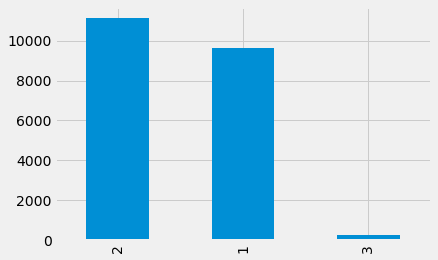

In [23]:
tr.marriage.value_counts().plot(kind = 'bar')

<AxesSubplot:>

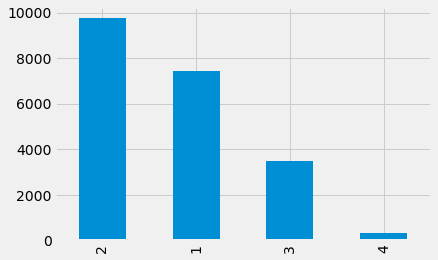

In [24]:
tr.education.value_counts().plot(kind="bar")

In [25]:
billed = tr[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']]
status = tr[['stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6']]
paid = tr[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']]

In [26]:
# con_1 = pd.melt(df, value_vars = col_con)
# g = sns.FacetGrid(con_1, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.distplot, 'value', color='r')
# g.set_xticklabels(rotation=45)
# plt.savefig("images/df_distplot.png")

# Create scatterplots with regression line with regplot() of continuous variables

# con_2 = pd.melt(df, id_vars='price', value_vars=col_con)
# g = sns.FacetGrid(con_2, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.regplot, 'value', 'price', color='darkorange')
# g.set_xticklabels(rotation=45)
# plt.savefig('images/df_scatter.png')

# Use bar graphs of the distribution of data for categorical variables

# cat_1 = pd.melt(df, value_vars=col_cat)
# g = sns.FacetGrid(cat_1, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.countplot, 'value', color='g')
# g.set_xticklabels(rotation=90)
# plt.savefig("images/df_countplot.png")

# Create scatterplots for categorical variables to observe any relationships

# cat_2 = pd.melt(df,id_vars='price', value_vars=col_cat)
# g = sns.FacetGrid(cat_2, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.regplot, 'value', 'price', color='dodgerblue')
# g.set_xticklabels(rotation=90)
# plt.savefig("images/df_regplot.png")

# Display boxplots of categorical variables to observe any trends in the mean values of each category

# cat_3 = pd.melt(df, id_vars='price', value_vars=col_cat)
# g = sns.FacetGrid(cat_3, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.boxplot, 'value', 'price', color='mediumslateblue')
# g.set_xticklabels(rotation=90)
# plt.savefig("images/df_boxplot.png")

In [28]:
def histogram(df, features, rows, cols, bins):
    fig = plt.figure(figsize=(16, 16))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        df[feature].hist(bins=bins, ax=ax)
        ax.set_title(feature)
    fig.tight_layout()
    plt.show()

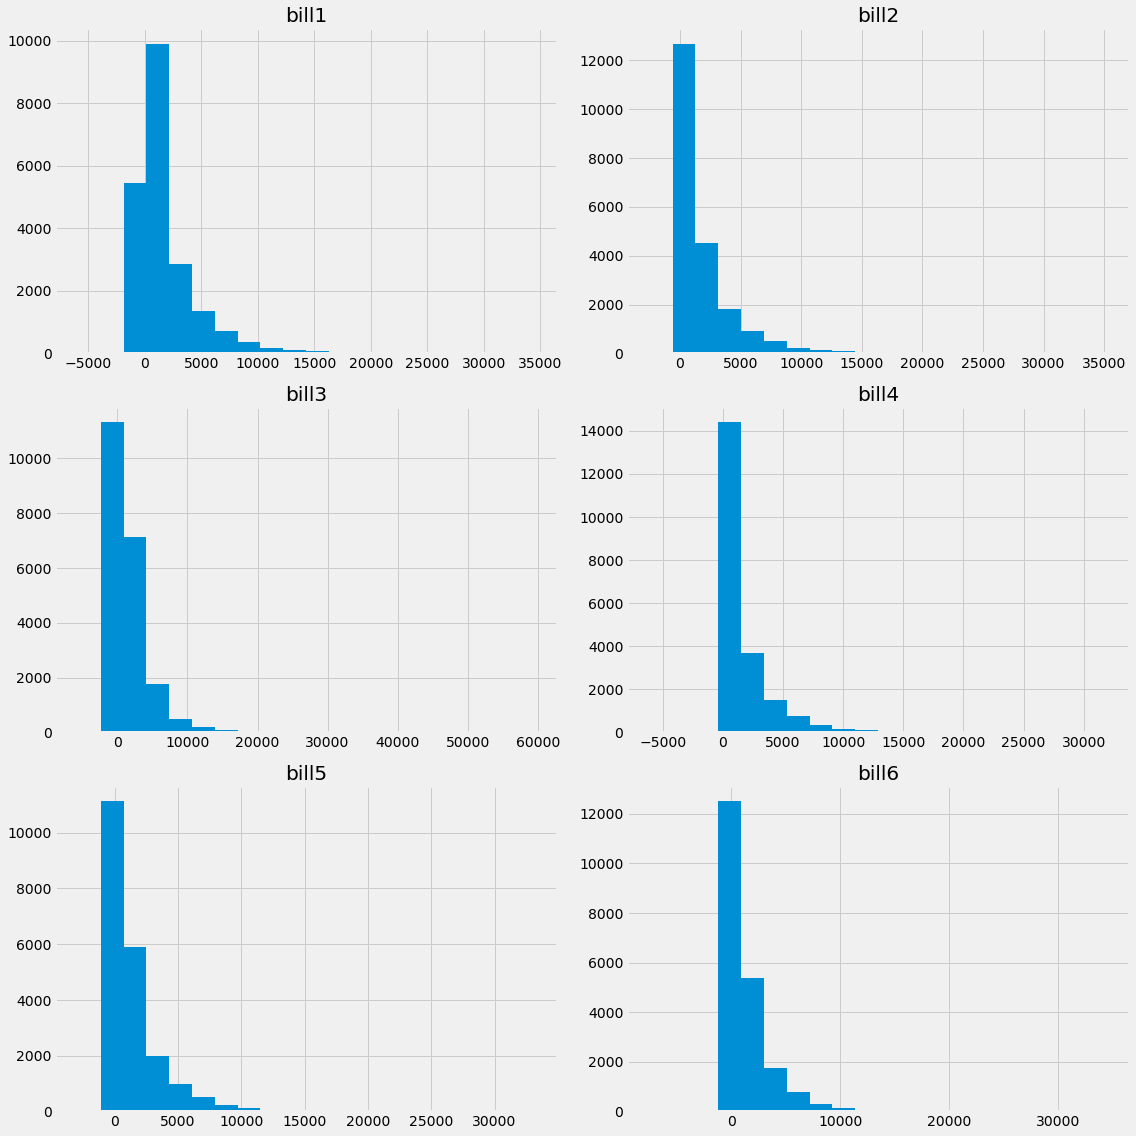

In [31]:
billed = tr[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']]
histogram(billed, billed.columns, 3, 2, 20)

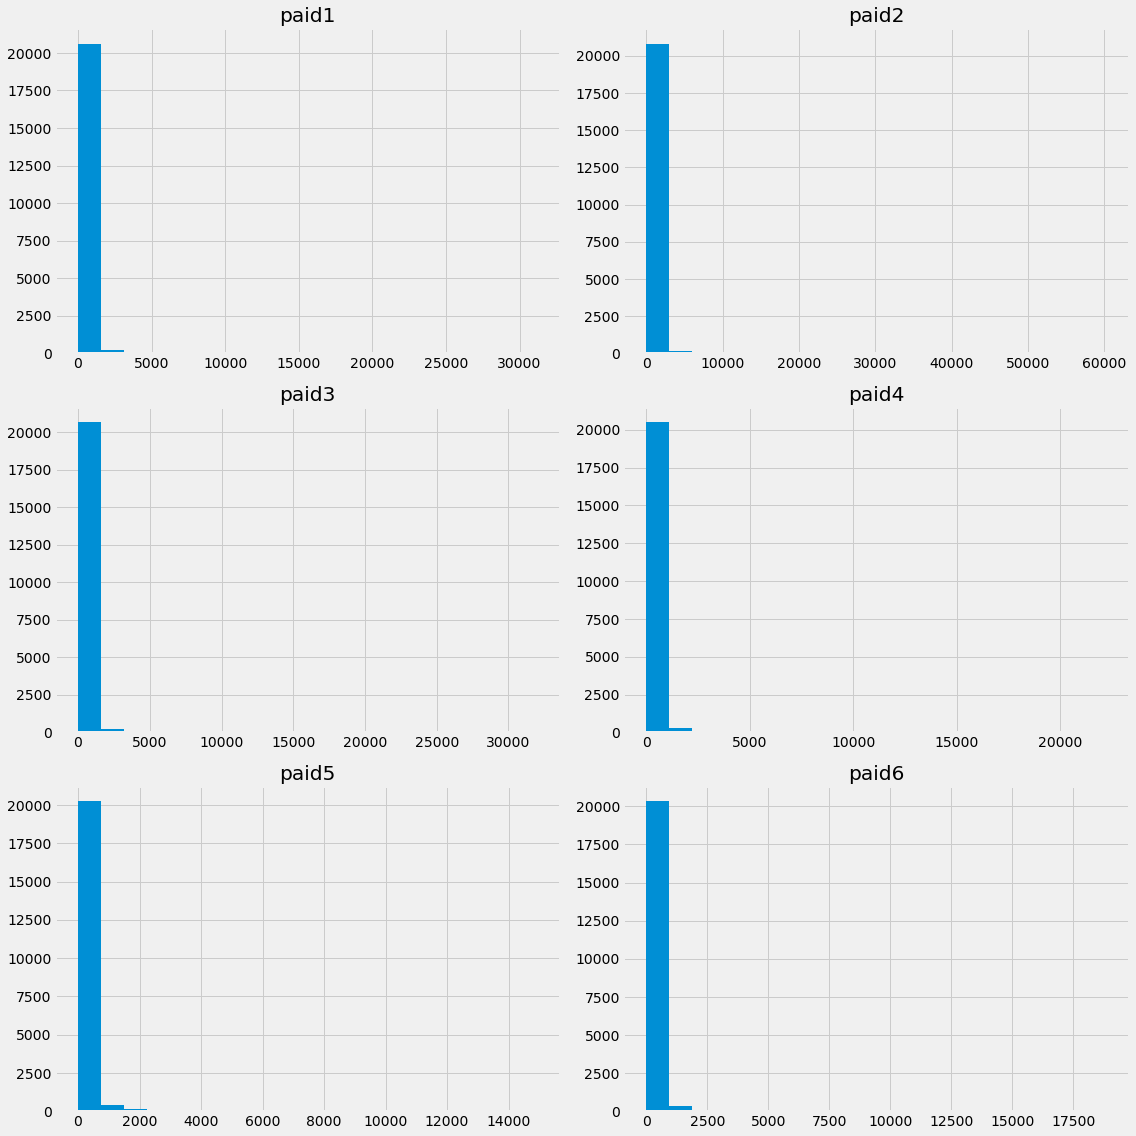

In [32]:
paid = tr[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']]
histogram(paid, paid.columns, 3, 2, 20)

<AxesSubplot:>

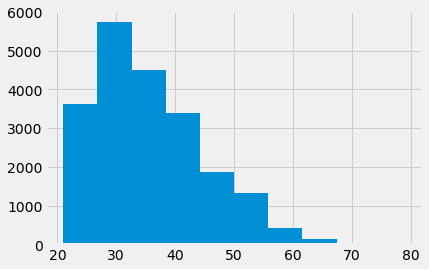

In [27]:
tr.age.hist()

<AxesSubplot:>

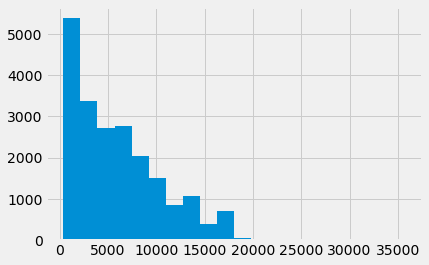

In [33]:
tr.limit.hist(bins=20)

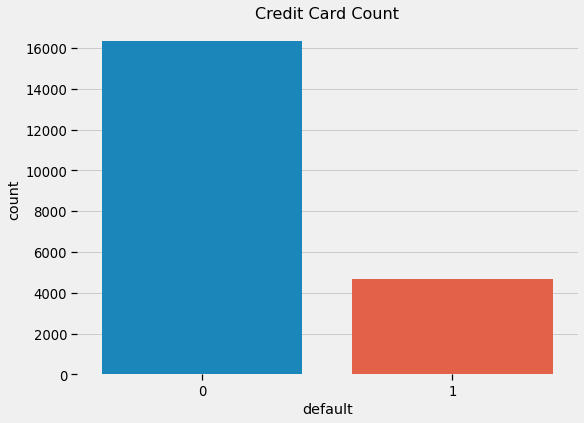

In [34]:
yes = tr.default.sum()
no = len(tr)-yes
perc_y = round(yes/len(tr)*100, 1)
perc_n = round(no/len(tr)*100, 1)

plt.figure(figsize=(8,6))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('default', data=tr)
plt.title('Credit Card Count', size=16)
plt.box(False);

In [37]:
print(yes)
print(no)
print(perc_y)
print(perc_n)

4656
16344
22.2
77.8


In [ ]:
plt.annotate('Non-default: {}'.format(no), xy=(-0.3, 15000), xytext=(-0.3, 3000))
plt.annotate('Default: {}'.format(yes), xy=(0.7, 15000), xytext=(0.7, 3000))
plt.annotate(str(perc_n)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000))
plt.annotate(str(perc_y)+" %", xy=(0.7, 15000), xytext=(0.9, 8000))

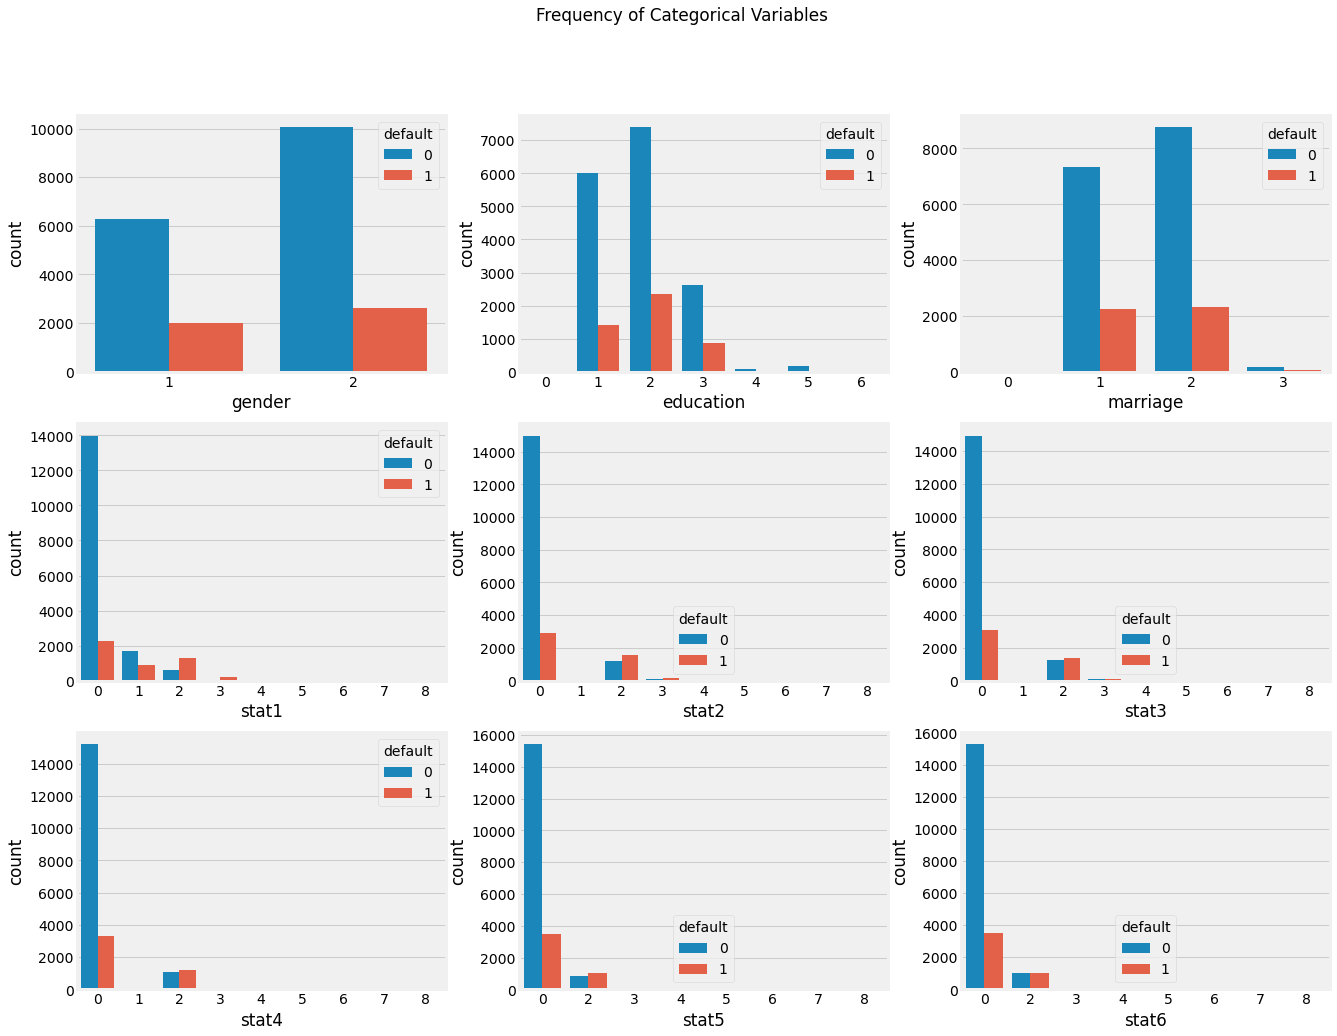

In [23]:
subset = tr[['gender', 'education', 'marriage', 'stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6', 'default']]

f, axes = plt.subplots(3, 3, figsize=(20, 15), facecolor='white')
f.suptitle('Frequency of Categorical Variables')
ax1 = sns.countplot(x="gender", hue="default", data=subset, ax=axes[0,0])
ax2 = sns.countplot(x="education", hue="default", data=subset, ax=axes[0,1])
ax3 = sns.countplot(x="marriage", hue="default", data=subset, ax=axes[0,2])
ax4 = sns.countplot(x="stat1", hue="default", data=subset, ax=axes[1,0])
ax5 = sns.countplot(x="stat2", hue="default", data=subset, ax=axes[1,1])
ax6 = sns.countplot(x="stat3", hue="default", data=subset, ax=axes[1,2])
ax7 = sns.countplot(x="stat4", hue="default", data=subset, ax=axes[2,0])
ax8 = sns.countplot(x="stat5", hue="default", data=subset, ax=axes[2,1])
ax9 = sns.countplot(x="stat6", hue="default", data=subset, ax=axes[2,2]);

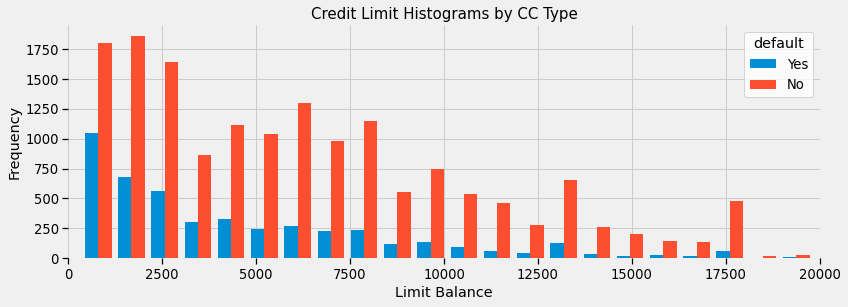

In [29]:
x1 = list(tr[tr['default'] == 1]['limit'])
x2 = list(tr[tr['default'] == 0]['limit'])

plt.figure(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40)
plt.xlim([0, 20000])
plt.legend(['Yes', 'No'], title = 'default', loc='upper right', facecolor='white')
plt.xlabel('Limit Balance')
plt.ylabel('Frequency')
plt.title('Credit Limit Histograms by CC Type', SIZE=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

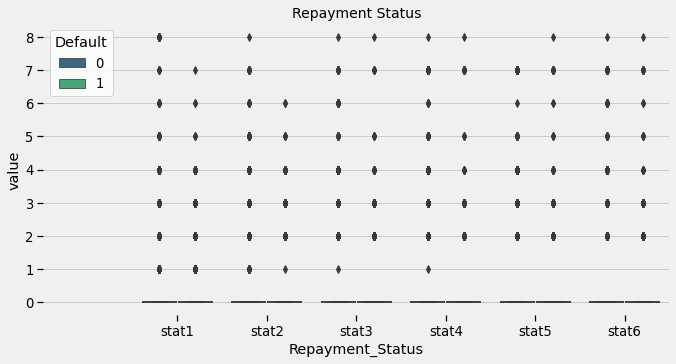

In [32]:
status = tr[['stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6']]
status = pd.concat([y, status],axis=1)
status = pd.melt(status,id_vars="default",
                    var_name="Repayment_Status",
                    value_name='value')

plt.figure(figsize=(10,5))
sns.set_context('notebook', font_scale=1.2)
sns.boxplot(y="value", x="Repayment_Status", hue="default", data=status, palette='viridis')
plt.legend(loc='best', title= 'Default', facecolor='white')
plt.xlim([-1.5,5.5])
plt.title('Repayment Status', size=14)
plt.box(False)

In [35]:
tr.head()

,limit,gender,education,marriage,age,stat_09,stat_08,stat_07,stat_06,stat_05,stat_04,bill_09,bill_08,bill_07,bill_06,bill_05,bill_04,paid_08,paid_07,paid_06,paid_05,paid_04,paid_03,default
0,6427.079428,2,2,1,29,0,0,0,0,0,0,135.075786,100.440969,29.957331,55.594237,1845.285916,1896.524021,71.411994,29.957331,25.636906,1814.721582,80.052845,39.276597,0
1,10354.739078,1,1,1,38,2,2,0,0,0,0,11569.314266,10532.412119,10618.463571,8696.481174,8632.460322,8441.361827,0.000000,433.435095,2856.479746,357.059968,301.465731,357.059968,1
2,3213.539714,2,2,1,34,1,2,2,0,0,0,286.397801,277.792655,0.000000,331.387357,0.000000,12.140039,2.749362,0.000000,331.387357,0.000000,12.140039,0.000000,0
3,7141.199364,2,2,2,31,0,0,0,0,0,0,53.808937,0.000000,7.783907,155.678146,0.000000,0.000000,0.000000,7.783907,155.678146,0.000000,0.000000,0.000000,0
4,3213.539714,2,1,2,29,0,0,0,0,0,0,318.747434,325.781515,364.915288,430.043026,994.304894,294.610180,285.647975,357.059968,357.631264,892.649921,285.647975,928.355917,0


In [38]:
data = ['limit', 'bill_04', 'paid_03', 'bill_05', 'paid_04', 'bill_06', 'paid_05', 'bill_07', 'paid_06', 'bill_08', 'paid_07', 'bill_09', 'paid_08']
for d in data:
    tr[d] = tr[d].map(lambda x: round(x, 2))


In [39]:
tr.head()

,limit,gender,education,marriage,age,stat_09,stat_08,stat_07,stat_06,stat_05,stat_04,bill_09,bill_08,bill_07,bill_06,bill_05,bill_04,paid_08,paid_07,paid_06,paid_05,paid_04,paid_03,default
0,6427.08,2,2,1,29,0,0,0,0,0,0,135.08,100.44,29.96,55.59,1845.29,1896.52,71.41,29.96,25.64,1814.72,80.05,39.28,0
1,10354.74,1,1,1,38,2,2,0,0,0,0,11569.31,10532.41,10618.46,8696.48,8632.46,8441.36,0.00,433.44,2856.48,357.06,301.47,357.06,1
2,3213.54,2,2,1,34,1,2,2,0,0,0,286.40,277.79,0.00,331.39,0.00,12.14,2.75,0.00,331.39,0.00,12.14,0.00,0
3,7141.20,2,2,2,31,0,0,0,0,0,0,53.81,0.00,7.78,155.68,0.00,0.00,0.00,7.78,155.68,0.00,0.00,0.00,0
4,3213.54,2,1,2,29,0,0,0,0,0,0,318.75,325.78,364.92,430.04,994.30,294.61,285.65,357.06,357.63,892.65,285.65,928.36,0


In [42]:
tr[['limit', 'paid_03', 'bill_04', 'paid_04', 'stat_04', 'bill_05', 'paid_05', 'stat_05', 'bill_06', 'paid_06', 'stat_06', 'bill_07', 'paid_07', 'stat_07', 'bill_08', 'stat_08', 'paid_08', 'bill_09', 'stat_09']]

,limit,paid_03,bill_04,paid_04,stat_04,bill_05,paid_05,stat_05,bill_06,paid_06,stat_06,bill_07,paid_07,stat_07,bill_08,stat_08,paid_08,bill_09,stat_09
0,6427.08,39.28,1896.52,80.05,0,1845.29,1814.72,0,55.59,25.64,0,29.96,29.96,0,100.44,0,71.41,135.08,0
1,10354.74,357.06,8441.36,301.47,0,8632.46,357.06,0,8696.48,2856.48,0,10618.46,433.44,0,10532.41,2,0.00,11569.31,2
2,3213.54,0.00,12.14,12.14,0,0.00,0.00,0,331.39,331.39,0,0.00,0.00,2,277.79,2,2.75,286.40,1
3,7141.20,0.00,0.00,0.00,0,0.00,0.00,0,155.68,155.68,0,7.78,7.78,0,0.00,0,0.00,53.81,0
4,3213.54,928.36,294.61,285.65,0,994.30,892.65,0,430.04,357.63,0,364.92,357.06,0,325.78,0,285.65,318.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,7855.32,14.14,19.50,19.50,0,14.14,14.14,0,14.14,14.14,0,14.14,14.14,0,14.14,2,0.00,28.28,0
17996,4998.84,80.87,62.27,62.45,0,17.67,17.71,0,91.87,92.12,0,54.06,54.34,0,183.89,0,72.27,104.87,0
17997,714.12,0.00,732.94,41.10,0,701.48,23.49,0,682.13,0.00,2,707.69,101.12,2,616.71,2,35.71,601.82,2
17998,1071.18,0.00,772.36,71.41,2,717.65,71.41,0,657.56,47.02,0,631.89,0.00,2,652.49,2,113.37,548.48,2


In [44]:
tr[tr.default == 1][['limit', 'paid_03', 'bill_04', 'paid_04', 'stat_04', 'bill_05', 'paid_05', 'stat_05', 'bill_06', 'paid_06', 'stat_06', 'bill_07', 'paid_07', 'stat_07', 'bill_08', 'paid_08', 'stat_08', 'bill_09', 'stat_09']]

,limit,paid_03,bill_04,paid_04,stat_04,bill_05,paid_05,stat_05,bill_06,paid_06,stat_06,bill_07,paid_07,stat_07,bill_08,paid_08,stat_08,bill_09,stat_09
1,10354.74,357.06,8441.36,301.47,0,8632.46,357.06,0,8696.48,2856.48,0,10618.46,433.44,0,10532.41,0.00,2,11569.31,2
10,714.12,0.00,42.85,0.00,5,64.27,0.00,6,85.69,0.00,7,85.69,0.00,7,85.69,0.00,2,85.69,2
12,4284.72,89.26,2265.30,89.26,2,2222.73,0.00,3,2280.58,174.96,2,2163.21,0.00,3,2218.73,210.67,2,2064.38,1
15,7855.32,0.00,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,1
24,357.06,0.00,337.28,35.49,0,133.15,2.68,0,130.47,35.71,0,97.69,0.00,2,218.13,134.79,0,86.66,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17983,5355.90,131.54,3124.27,2856.48,0,291.83,29.39,0,266.87,4284.72,0,5265.71,107.12,0,5416.10,4820.95,0,629.68,2
17984,1785.30,21.42,723.51,249.94,0,717.15,107.12,0,844.98,212.31,0,1523.65,89.26,0,1696.64,78.55,0,1691.54,0
17987,6070.02,26.42,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,0
17997,714.12,0.00,732.94,41.10,0,701.48,23.49,0,682.13,0.00,2,707.69,101.12,2,616.71,35.71,2,601.82,2


In [45]:
tr[tr.default == 1][['limit', 'bill_04', 'paid_03', 'stat_04', 'bill_05', 'paid_04', 'stat_05', 'bill_06', 'paid_05', 'stat_06', 'bill_07', 'paid_06', 'stat_07', 'bill_08', 'paid_07', 'stat_08', 'bill_09', 'paid_08', 'stat_09']]

,limit,bill_04,paid_03,stat_04,bill_05,paid_04,stat_05,bill_06,paid_05,stat_06,bill_07,paid_06,stat_07,bill_08,paid_07,stat_08,bill_09,paid_08,stat_09
1,10354.74,8441.36,357.06,0,8632.46,301.47,0,8696.48,357.06,0,10618.46,2856.48,0,10532.41,433.44,2,11569.31,0.00,2
10,714.12,42.85,0.00,5,64.27,0.00,6,85.69,0.00,7,85.69,0.00,7,85.69,0.00,2,85.69,0.00,2
12,4284.72,2265.30,89.26,2,2222.73,89.26,3,2280.58,0.00,2,2163.21,174.96,3,2218.73,0.00,2,2064.38,210.67,1
15,7855.32,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,0,0.00,0.00,1
24,357.06,337.28,0.00,0,133.15,35.49,0,130.47,2.68,0,97.69,35.71,2,218.13,0.00,0,86.66,134.79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17983,5355.90,3124.27,131.54,0,291.83,2856.48,0,266.87,29.39,0,5265.71,4284.72,0,5416.10,107.12,0,629.68,4820.95,2
17984,1785.30,723.51,21.42,0,717.15,249.94,0,844.98,107.12,0,1523.65,212.31,0,1696.64,89.26,0,1691.54,78.55,0
17987,6070.02,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0
17997,714.12,732.94,0.00,0,701.48,41.10,0,682.13,23.49,2,707.69,0.00,2,616.71,101.12,2,601.82,35.71,2
